original notebook: https://colab.research.google.com/github/ashkamath/mdetr/blob/colab/notebooks/MDETR_demo.ipynb

In [1]:
import warnings
warnings.filterwarnings("ignore")

# MDETR on DAQUAR

## Data

Let's download data from https://www.mpi-inf.mpg.de/departments/computer-vision-and-machine-learning/research/vision-and-language/visual-turing-challenge/

In [2]:
!wget -q http://datasets.d2.mpi-inf.mpg.de/mateusz14visual-turing/nyu_depth_images.tar
!tar -xf nyu_depth_images.tar
!wget -q http://datasets.d2.mpi-inf.mpg.de/mateusz14visual-turing/qa.894.raw.train.txt
!wget -q http://datasets.d2.mpi-inf.mpg.de/mateusz14visual-turing/qa.894.raw.test.txt
!wget -q http://datasets.d2.mpi-inf.mpg.de/mateusz14visual-turing/train.txt
!wget -q http://datasets.d2.mpi-inf.mpg.de/mateusz14visual-turing/test.txt

Creating dataframe with path to image and corresponding question and answer:

In [3]:
import pandas as pd

with open("qa.894.raw.train.txt") as f:
    lines = f.readlines()
    questions = [q.rstrip() for q in lines[::2]]
    answers = [a.rstrip() for a in lines[1::2]]
    paths = [f"nyu_depth_images/{q.rsplit(' ', 2)[1]}.png" for q in questions]
train_data = pd.DataFrame({
    "path" : paths,
    "question" : questions,
    "answer" : answers
})
train_data.head(3)

,path,question,answer
0,nyu_depth_images/image3.png,what is on the right side of the black telepho...,desk
1,nyu_depth_images/image3.png,what is in front of the white door on the left...,telephone
2,nyu_depth_images/image3.png,what is on the desk in the image3 ?,"book, scissor, papers, tape_dispenser"


Example element of dataset:

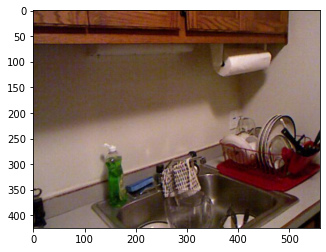

Q:  what is the colour the mat beneath the kitchen utensils in the image574 ?
A:  red


In [4]:
import matplotlib.pyplot as plt

sample = train_data.sample(1).iloc[0]
image = plt.imread(sample['path'])
plt.imshow(image)
plt.show()
print("Q: ", sample['question'])
print("A: ", sample['answer'])

## MDETR

In [5]:
!git clone https://github.com/ashkamath/mdetr.git
!pip install -qr mdetr/requirements.txt

Cloning into 'mdetr'...
remote: Enumerating objects: 189, done.
remote: Counting objects: 100% (189/189), done.
remote: Compressing objects: 100% (150/150), done.
remote: Total 189 (delta 69), reused 145 (delta 38), pack-reused 0
Receiving objects: 100% (189/189), 9.64 MiB | 12.39 MiB/s, done.
Resolving deltas: 100% (69/69), done.
     |████████████████████████████████| 2.1 MB 3.9 MB/s 
     |████████████████████████████████| 12.7 MB 36.7 MB/s 
     |████████████████████████████████| 4.8 MB 36.0 MB/s 
     |████████████████████████████████| 69 kB 5.7 MB/s 
     |████████████████████████████████| 376 kB 44.2 MB/s 
     |████████████████████████████████| 895 kB 41.5 MB/s 
     |████████████████████████████████| 3.3 MB 36.8 MB/s 


In [6]:
import torch
model_qa = torch.hub.load('ashkamath/mdetr:main', 'mdetr_efficientnetB5_gqa', pretrained=True, return_postprocessor=False)
model_qa = model_qa.cuda()
model_qa.eval();

Downloading: "https://github.com/ashkamath/mdetr/archive/main.zip" to /root/.cache/torch/hub/main.zip
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b5_ns-6f26d0cf.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b5_ns-6f26d0cf.pth


Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/501M [00:00<?, ?B/s]

Downloading: "https://zenodo.org/record/4721981/files/gqa_EB5_checkpoint.pth" to /root/.cache/torch/hub/checkpoints/gqa_EB5_checkpoint.pth


  0%|          | 0.00/2.54G [00:00<?, ?B/s]

In [18]:
import torchvision.transforms as T
from collections import defaultdict
import numpy as np
import requests
import json
answer2id_by_type = json.load(requests.get("https://nyu.box.com/shared/static/j4rnpo8ixn6v0iznno2pim6ffj3jyaj8.json", stream=True).raw)
id2answerbytype = {}                                                       
for ans_type in answer2id_by_type.keys():                        
    curr_reversed_dict = {v: k for k, v in answer2id_by_type[ans_type].items()}
    id2answerbytype[ans_type] = curr_reversed_dict                             

transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b
# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

def apply_mask(image, mask, color, alpha=0.5):
    """Apply the given mask to the image.
    """
    for c in range(3):
        image[:, :, c] = np.where(mask == 1,
                                  image[:, :, c] *
                                  (1 - alpha) + alpha * color[c] * 255,
                                  image[:, :, c])
    return image

def plot_results(pil_img, scores, boxes, labels, masks=None):
    plt.figure(figsize=(16,10))
    np_image = np.array(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    if masks is None:
      masks = [None for _ in range(len(scores))]
    assert len(scores) == len(boxes) == len(labels) == len(masks)
    for s, (xmin, ymin, xmax, ymax), l, mask, c in zip(scores, boxes.tolist(), labels, masks, colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        text = f'{l}: {s:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15, bbox=dict(facecolor='white', alpha=0.8))

        if mask is None:
          continue
        np_image = apply_mask(np_image, mask, c)

        padded_mask = np.zeros((mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8)
        padded_mask[1:-1, 1:-1] = mask
        contours = find_contours(padded_mask, 0.5)
        for verts in contours:
          # Subtract the padding and flip (y, x) to (x, y)
          verts = np.fliplr(verts) - 1
          p = Polygon(verts, facecolor="none", edgecolor=c)
          ax.add_patch(p)


    plt.imshow(np_image)
    plt.axis('off')
    plt.show()


def add_res(results, ax, color='green'):
    #for tt in results.values():
    if True:
        bboxes = results['boxes']
        labels = results['labels']
        scores = results['scores']
        #keep = scores >= 0.0
        #bboxes = bboxes[keep].tolist()
        #labels = labels[keep].tolist()
        #scores = scores[keep].tolist()
    #print(torchvision.ops.box_iou(tt['boxes'].cpu().detach(), torch.as_tensor([[xmin, ymin, xmax, ymax]])))
    
    colors = ['purple', 'yellow', 'red', 'green', 'orange', 'pink']
    
    for i, (b, ll, ss) in enumerate(zip(bboxes, labels, scores)):
        ax.add_patch(plt.Rectangle((b[0], b[1]), b[2] - b[0], b[3] - b[1], fill=False, color=colors[i], linewidth=3))
        cls_name = ll if isinstance(ll,str) else CLASSES[ll]
        text = f'{cls_name}: {ss:.2f}'
        print(text)
        ax.text(b[0], b[1], text, fontsize=15, bbox=dict(facecolor='white', alpha=0.8))

def plot_inference_qa(im, caption):
  # mean-std normalize the input image (batch-size: 1)
  img = transform(im).unsqueeze(0).cuda()

  # propagate through the model
  memory_cache = model_qa(img, [caption], encode_and_save=True)
  outputs = model_qa(img, [caption], encode_and_save=False, memory_cache=memory_cache)

  # keep only predictions with 0.7+ confidence
  probas = 1 - outputs['pred_logits'].softmax(-1)[0, :, -1].cpu()
  keep = (probas > 0.7).cpu()

  # convert boxes from [0; 1] to image scales
  bboxes_scaled = rescale_bboxes(outputs['pred_boxes'].cpu()[0, keep], im.size)

  # Extract the text spans predicted by each box
  positive_tokens = (outputs["pred_logits"].cpu()[0, keep].softmax(-1) > 0.1).nonzero().tolist()
  predicted_spans = defaultdict(str)
  for tok in positive_tokens:
    item, pos = tok
    if pos < 255:
        span = memory_cache["tokenized"].token_to_chars(0, pos)
        predicted_spans [item] += " " + caption[span.start:span.end]

  labels = [predicted_spans [k] for k in sorted(list(predicted_spans .keys()))]
  plot_results(im, probas[keep], bboxes_scaled, labels)

  # Classify the question type
  type_conf, type_pred = outputs["pred_answer_type"].softmax(-1).max(-1)
  ans_type = type_pred.item()
  types = ["obj", "attr", "rel", "global", "cat"]
  ans_conf, ans = outputs[f"pred_answer_{types[ans_type]}"][0].softmax(-1).max(-1)
  answer = id2answerbytype[f"answer_{types[ans_type]}"][ans.item()]
  print(f"Predicted answer: {answer}\t confidence={round(100 * type_conf.item() * ans_conf.item(), 2)}")

In [19]:
torch.cuda.empty_cache()

Q:  what is the largest object in the image65 ?
A:  blanket


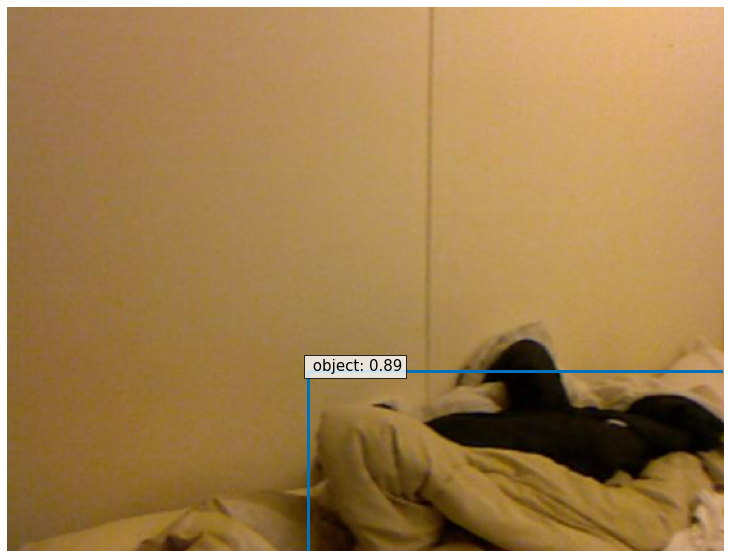

Predicted answer: laptop	 confidence=42.74


In [47]:
from PIL import Image

sample = train_data.sample(1).iloc[0]
image = Image.open(sample['path'])
print("Q: ", sample['question'])
print("A: ", sample['answer'])
plot_inference_qa(image, sample['question'])

# MDETR on pets

In [12]:
!wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!tar -xf images.tar.gz
!wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xf annotations.tar.gz
!pip install -q transformers timm

--2021-11-24 10:24:24--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 791918971 (755M) [application/x-gzip]
Saving to: ‘images.tar.gz’

images.tar.gz       100%[===================>] 755.23M   104MB/s    in 7.5s    

2021-11-24 10:24:31 (101 MB/s) - ‘images.tar.gz’ saved [791918971/791918971]

--2021-11-24 10:24:40--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19173078 (18M) [application/x-gzip]
Saving to: ‘annotations.tar.gz’

annotations.tar.gz  100%[===================>]  18.28M  83.4MB/s    in 0.2s    

2021-11-24 10:24:40 (83.4 MB

In [13]:
import torch
model_pc = torch.hub.load('ashkamath/mdetr:main', 'mdetr_efficientnetB3_phrasecut', pretrained=True, return_postprocessor=False)
model_pc = model_pc.cuda()
model_pc.eval();

Using cache found in /root/.cache/torch/hub/ashkamath_mdetr_main
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b3_ns-9d44bf68.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b3_ns-9d44bf68.pth
Downloading: "https://zenodo.org/record/4721981/files/phrasecut_EB3_checkpoint.pth" to /root/.cache/torch/hub/checkpoints/phrasecut_EB3_checkpoint.pth


  0%|          | 0.00/1.16G [00:00<?, ?B/s]

In [48]:
import numpy as np
import requests
import matplotlib.pyplot as plt
import json
import torch
from PIL import Image
import requests
import torchvision.transforms as T
import matplotlib.pyplot as plt
from collections import defaultdict
import torch.nn.functional as F
import numpy as np
from skimage.measure import find_contours

from matplotlib import patches,  lines
from matplotlib.patches import Polygon

torch.set_grad_enabled(False);

answer2id_by_type = json.load(requests.get("https://nyu.box.com/shared/static/j4rnpo8ixn6v0iznno2pim6ffj3jyaj8.json", stream=True).raw)
id2answerbytype = {}                                                       
for ans_type in answer2id_by_type.keys():                        
    curr_reversed_dict = {v: k for k, v in answer2id_by_type[ans_type].items()}
    id2answerbytype[ans_type] = curr_reversed_dict                             

transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b
# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

def apply_mask(image, mask, color, alpha=0.5):
    """Apply the given mask to the image.
    """
    for c in range(3):
        image[:, :, c] = np.where(mask == 1,
                                  image[:, :, c] *
                                  (1 - alpha) + alpha * color[c] * 255,
                                  image[:, :, c])
    return image

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

def apply_mask(image, mask, color, alpha=0.5):
    """Apply the given mask to the image.
    """
    for c in range(3):
        image[:, :, c] = np.where(mask == 1,
                                  image[:, :, c] *
                                  (1 - alpha) + alpha * color[c] * 255,
                                  image[:, :, c])
    return image

def plot_results(pil_img, scores, boxes, labels, masks=None):
    plt.figure(figsize=(16,10))
    np_image = np.array(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    if masks is None:
      masks = [None for _ in range(len(scores))]
    assert len(scores) == len(boxes) == len(labels) == len(masks)
    for s, (xmin, ymin, xmax, ymax), l, mask, c in zip(scores, boxes.tolist(), labels, masks, colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        text = f'{l}: {s:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15, bbox=dict(facecolor='white', alpha=0.8))

        if mask is None:
          continue
        np_image = apply_mask(np_image, mask, c)

        padded_mask = np.zeros((mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8)
        padded_mask[1:-1, 1:-1] = mask
        contours = find_contours(padded_mask, 0.5)
        for verts in contours:
          # Subtract the padding and flip (y, x) to (x, y)
          verts = np.fliplr(verts) - 1
          p = Polygon(verts, facecolor="none", edgecolor=c)
          ax.add_patch(p)


    plt.imshow(np_image)
    plt.axis('off')
    plt.show()


def add_res(results, ax, color='green'):
    #for tt in results.values():
    if True:
        bboxes = results['boxes']
        labels = results['labels']
        scores = results['scores']
        #keep = scores >= 0.0
        #bboxes = bboxes[keep].tolist()
        #labels = labels[keep].tolist()
        #scores = scores[keep].tolist()
    #print(torchvision.ops.box_iou(tt['boxes'].cpu().detach(), torch.as_tensor([[xmin, ymin, xmax, ymax]])))
    
    colors = ['purple', 'yellow', 'red', 'green', 'orange', 'pink']
    
    for i, (b, ll, ss) in enumerate(zip(bboxes, labels, scores)):
        ax.add_patch(plt.Rectangle((b[0], b[1]), b[2] - b[0], b[3] - b[1], fill=False, color=colors[i], linewidth=3))
        cls_name = ll if isinstance(ll,str) else CLASSES[ll]
        text = f'{cls_name}: {ss:.2f}'
        print(text)
        ax.text(b[0], b[1], text, fontsize=15, bbox=dict(facecolor='white', alpha=0.8))

def plot_inference_segmentation(im, caption):
  # mean-std normalize the input image (batch-size: 1)
  img = transform(im).unsqueeze(0).cuda()

  # propagate through the model
  outputs = model_pc(img, [caption])

  # keep only predictions with 0.9+ confidence
  probas = 1 - outputs['pred_logits'].softmax(-1)[0, :, -1].cpu()
  keep = (probas > 0.9).cpu()

  # convert boxes from [0; 1] to image scales
  bboxes_scaled = rescale_bboxes(outputs['pred_boxes'].cpu()[0, keep], im.size)

  # Interpolate masks to the correct size
  w, h = im.size
  masks = F.interpolate(outputs["pred_masks"], size=(h, w), mode="bilinear", align_corners=False)
  masks = masks.cpu()[0, keep].sigmoid() > 0.5

  tokenized = model_pc.detr.transformer.tokenizer.batch_encode_plus([caption], padding="longest", return_tensors="pt").to(img.device)

  # Extract the text spans predicted by each box
  positive_tokens = (outputs["pred_logits"].cpu()[0, keep].softmax(-1) > 0.1).nonzero().tolist()
  predicted_spans = defaultdict(str)
  for tok in positive_tokens:
    item, pos = tok
    if pos < 255:
        span = tokenized.token_to_chars(0, pos)
        predicted_spans [item] += " " + caption[span.start:span.end]

  labels = [predicted_spans [k] for k in sorted(list(predicted_spans .keys()))]
  plot_results(im, probas[keep], bboxes_scaled, labels, masks)
  return bboxes_scaled

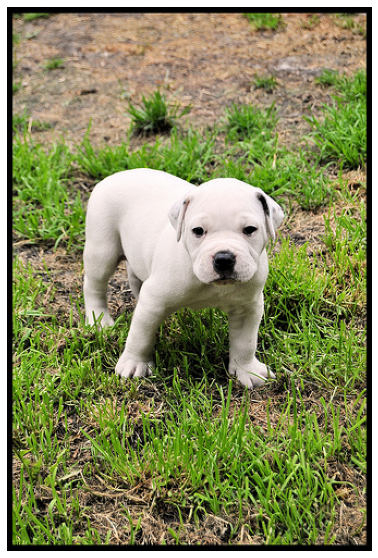

In [71]:
from PIL import Image

im2 = Image.open("images/american_bulldog_109.jpg")
outputs = plot_inference_segmentation(im2, "house")

In [ ]:
# 

In [ ]:
true_positive_dogs = 0
true_positive_cats = 0
false_positive_dogs = 0
false_positive_cats = 0
total_dogs = 0
total_cats = 0

with open("annotations/trainval.txt") as f:
  for line in f:
    try:
      filename = line.split()[0]
      filepath = f"images/{filename}.jpg"
      image = Image.open(filepath)
      if filename[0].islower(): #dog
        outputs = plot_inference_segmentation(image, "cat")
        false_positive_dogs += (outputs.size(0) != 0)
        outputs = plot_inference_segmentation(image, "dog")
        true_positive_dogs += (outputs.size(0) != 0)
        total_dogs += 1
      else: #cat
        outputs = plot_inference_segmentation(image, "dog")
        false_positive_cats += (outputs.size(0) != 0)
        outputs = plot_inference_segmentation(image, "cat")
        true_positive_cats += (outputs.size(0) != 0)
        total_cats += 1
    except: 
      print("oh no")
    torch.cuda.empty_cache()

true_positive_cats / total_cats, true_positive_dogs / total_dogs, false_positive_cats / total_cats, false_positive_dogs / total_dogs 

In [ ]:
import os
os.chdir("mdetr")

In [ ]:
!python main.py --dataset_config configs/pretrain.json --ema